#Predicción de Tiempos Verbales

###1.Utilizamos GPU

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


###2.Instalación de librerías y descarga del dataset

Se instalan las librerías necesarias y se descarga el archivo armado en el notebook de Descarga Dataset que contiene las oraciones y etiquetas gramaticales que serán utilizadas para entrenar el modelo

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=69fdb76be372099d72307b4cbca2dbdb7e36564619dfcdbf93003bad32a8dd52
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://github.com/AndreTati/PrediccionTiemposVerbales/archive/refs/heads/main.zip'

# Download the file (if we haven't already)
if not os.path.exists('./main.zip'):
    wget.download(url, './main.zip')

In [ ]:
if not os.path.exists('./main/'):
    !unzip main.zip

Archive:  main.zip
bead8f482fada99d16d0d8246198a5b3bc9a58ae
   creating: PrediccionTiemposVerbales-main/
  inflating: PrediccionTiemposVerbales-main/README.md  
   creating: PrediccionTiemposVerbales-main/data/
  inflating: PrediccionTiemposVerbales-main/data/ancora_verbos.txt  
 extracting: PrediccionTiemposVerbales-main/data/master.zip  
   creating: PrediccionTiemposVerbales-main/dev/
  inflating: PrediccionTiemposVerbales-main/dev/model_dev.ipynb  
   creating: PrediccionTiemposVerbales-main/prod/
  inflating: PrediccionTiemposVerbales-main/prod/app.py  
  inflating: PrediccionTiemposVerbales-main/prod/label_dicts.pkl  
  inflating: PrediccionTiemposVerbales-main/prod/model.py  
  inflating: PrediccionTiemposVerbales-main/prod/modelMood.pth  
  inflating: PrediccionTiemposVerbales-main/prod/modelNumber.pth  
  inflating: PrediccionTiemposVerbales-main/prod/modelPerson.pth  
  inflating: PrediccionTiemposVerbales-main/prod/modelTime.pth  
  inflating: PrediccionTiemposVerbales-main/

In [ ]:
import pandas as pd
# Leer el archivo .txt sin encabezado (sin nombres de columnas)
df = pd.read_csv("/content/PrediccionTiemposVerbales-main/data/ancora_verbos.txt", sep="\t", header=None)

# Asignar nombres de columnas manualmente
df.columns = ["sentence", "verb", "Tense", "Mood", "Person", "Number"]

train_data = df.to_dict(orient="records")

###3.Tokenizamos con BERT

Se importan dos elementos del paquete transformers de HuggingFace:


*   BertTokenizer: convierte texto en tokens que el modelo puede procesar
*   BertModel: modelo base de BERT preentrenado que permite extraer embeddings de los tokens

Se carga un modelo de BERT preentrenado en español de la universidad de Chile



In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Cargar tokenizer en español
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", output_hidden_states=True)
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Se declaran dos funciones, la primera que tokeniza la oración y devuelve dichos tokens y los hidden_states que son los embeddings contextualizados de las distintas capas ocultas del modelo.
La segunda recibe lo que devuelve la primera y el verbo del cual debe extraer el token y los embeddings para después dependiendo de la estrategia de contextualización que reciba es lo que hace con dichos embeddings que luego devuelve para armar el dataset

In [ ]:
def get_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states
    return inputs, hidden_states

def get_verb_embedding(inputs, hidden_states, verb, strategy):
    # Convertir input_ids a tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    #print(tokens)
    # Tokenizar el verbo para saber cómo está dividido
    verb_subtokens = tokenizer.tokenize(verb)
    #print(verb_subtokens)
    # Encontrar los índices de los subtokens del verbo en la secuencia
    verb_indices=[]
    # Buscar los índices de los subtokens del verbo en la secuencia
    for i in range(len(tokens) - len(verb_subtokens) + 1):
        if tokens[i:i + len(verb_subtokens)] == verb_subtokens:
            verb_indices = list(range(i, i + len(verb_subtokens)))
            #print(verb_indices)
            break
    if not verb_indices:
        return None  # Verbo no encontrado

    # === Embedding según estrategia ===
    if strategy == "second_last":
        emb = torch.stack([hidden_states[-2][0][i] for i in verb_indices], dim=0)
        return emb.mean(dim=0).cpu()

    elif strategy == "sum_last4":
        emb = sum(hidden_states[-i][0][verb_indices].mean(dim=0) for i in range(1, 5))
        return emb.cpu()

    elif strategy == "concat_last4":
        emb = [hidden_states[-i][0][verb_indices].mean(dim=0) for i in range(1, 5)]
        return torch.cat(emb, dim=-1).cpu()

    elif strategy == "sum_all":
        emb = sum(hidden_states[i][0][verb_indices].mean(dim=0) for i in range(1, 13))
        return emb.cpu()

    else:
        raise ValueError(f"Estrategia desconocida: {strategy}")

Se recorre lo extraido del archivo y por cada registro se tokeniza la oración, se obtienen los embeddings contextualizados y se arman los datasets que se utilizaran luego para entrenar el modelo.
Se arma un dataset para tiempo y modo combinado, persona y número usando las 4 estrategias seleccionadas con el fin de definir con cuál se obtiene mejor resultado en cada clasificación

In [ ]:
dataset_time_mood_secondlast, dataset_time_mood_sumlast4, dataset_time_mood_concatlast4, dataset_time_mood_sumall = [], [], [], []
dataset_mood_secondlast, dataset_mood_sumlast4, dataset_mood_concatlast4, dataset_mood_sumall = [], [], [], []
dataset_person_secondlast, dataset_person_sumlast4, dataset_person_concatlast4, dataset_person_sumall = [], [], [], []
dataset_number_secondlast, dataset_number_sumlast4, dataset_number_concatlast4, dataset_number_sumall = [], [], [], []

for row in train_data:
    inputs, hidden_states = get_bert_embeddings(row["sentence"])
    if hidden_states is not None:
        #tense
        combined_label = row["Tense"] + "_" + row["Mood"]
        embTense_secondlast = get_verb_embedding(inputs, hidden_states, row["verb"], "second_last")
        dataset_time_mood_secondlast.append([row["verb"], embTense_secondlast, combined_label])
        embTense_sumlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_last4")
        dataset_time_mood_sumlast4.append([row["verb"], embTense_sumlast4, combined_label])
        embTense_concatlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "concat_last4")
        dataset_time_mood_concatlast4.append([row["verb"], embTense_concatlast4, combined_label])
        embTense_sumall = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_all")
        dataset_time_mood_sumall.append([row["verb"], embTense_sumall, combined_label])

        #mood
        """embMood_secondlast = get_verb_embedding(inputs, hidden_states, row["verb"], "second_last")
        dataset_mood_secondlast.append([row["verb"], embMood_secondlast, row["Mood"]])
        embMood_sumlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_last4")
        dataset_mood_sumlast4.append([row["verb"], embMood_sumlast4, row["Mood"]])
        embMood_concatlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "concat_last4")
        dataset_mood_concatlast4.append([row["verb"], embMood_concatlast4, row["Mood"]])
        embMood_sumall = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_all")
        dataset_mood_sumall.append([row["verb"], embMood_sumall, row["Mood"]])"""

        #person
        embPerson_secondlast = get_verb_embedding(inputs, hidden_states, row["verb"], "second_last")
        dataset_person_secondlast.append([row["verb"], embPerson_secondlast, row["Person"]])
        embPerson_sumlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_last4")
        dataset_person_sumlast4.append([row["verb"], embPerson_sumlast4, row["Person"]])
        embPerson_concatlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "concat_last4")
        dataset_person_concatlast4.append([row["verb"], embPerson_concatlast4, row["Person"]])
        embPerson_sumall = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_all")
        dataset_person_sumall.append([row["verb"], embPerson_sumall, row["Person"]])

        #number
        embNumber_secondlast = get_verb_embedding(inputs, hidden_states, row["verb"], "second_last")
        dataset_number_secondlast.append([row["verb"], embNumber_secondlast, row["Number"]])
        embNumber_sumlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_last4")
        dataset_number_sumlast4.append([row["verb"], embNumber_sumlast4, row["Number"]])
        embNumber_concatlast4 = get_verb_embedding(inputs, hidden_states, row["verb"], "concat_last4")
        dataset_number_concatlast4.append([row["verb"], embNumber_concatlast4, row["Number"]])
        embNumber_sumall = get_verb_embedding(inputs, hidden_states, row["verb"], "sum_all")
        dataset_number_sumall.append([row["verb"], embNumber_sumall, row["Number"]])

Se obtienen las etiquetas codificadas de cada clases

In [ ]:
# Extraer etiquetas únicas de cada lista
all_time_mood = sorted(set(row[2] for row in dataset_time_mood_secondlast))
#all_moods = sorted(set(row[2] for row in dataset_mood_secondlast))
all_persons = sorted(set(row[2] for row in dataset_person_secondlast))
all_numbers = sorted(set(row[2] for row in dataset_number_secondlast))

# Crear diccionarios {etiqueta_str: clase_int}
tense_mood2id = {label: idx for idx, label in enumerate(all_time_mood)}
#mood2id = {label: idx for idx, label in enumerate(all_moods)}
person2id = {label: idx for idx, label in enumerate(all_persons)}
number2id = {label: idx for idx, label in enumerate(all_numbers)}

In [ ]:
print(all_time_mood)
print(all_persons)
print(all_numbers)

['Fut_Ind', 'Imp_Ind', 'Imp_Sub', 'Past_Ind', 'Pres_Ind', 'Pres_Sub']
[1, 2, 3]
['Plur', 'Sing']


In [ ]:
dataset_time_secondlast = [[verb, emb, tense_mood2id[label]] for verb, emb, label in dataset_time_mood_secondlast]
dataset_time_sumlast4 = [[verb, emb, tense_mood2id[label]] for verb, emb, label in dataset_time_mood_sumlast4]
dataset_time_concatlast4 = [[verb, emb, tense_mood2id[label]] for verb, emb, label in dataset_time_mood_concatlast4]
dataset_time_sumall = [[verb, emb, tense_mood2id[label]] for verb, emb, label in dataset_time_mood_sumall]

"""dataset_mood_secondlast = [[verb, emb, mood2id[label]] for verb, emb, label in dataset_mood_secondlast]
dataset_mood_sumlast4 = [[verb, emb, mood2id[label]] for verb, emb, label in dataset_mood_sumlast4]
dataset_mood_concatlast4 = [[verb, emb, mood2id[label]] for verb, emb, label in dataset_mood_concatlast4]
dataset_mood_sumall = [[verb, emb, mood2id[label]] for verb, emb, label in dataset_mood_sumall]"""

dataset_person_secondlast = [[verb, emb, person2id[label]] for verb, emb, label in dataset_person_secondlast]
dataset_person_sumlast4 = [[verb, emb, person2id[label]] for verb, emb, label in dataset_person_sumlast4]
dataset_person_concatlast4 = [[verb, emb, person2id[label]] for verb, emb, label in dataset_person_concatlast4]
dataset_person_sumall = [[verb, emb, person2id[label]] for verb, emb, label in dataset_person_sumall]

dataset_number_secondlast = [[verb, emb, number2id[label]] for verb, emb, label in dataset_number_secondlast]
dataset_number_sumlast4 = [[verb, emb, number2id[label]] for verb, emb, label in dataset_number_sumlast4]
dataset_number_concatlast4 = [[verb, emb, number2id[label]] for verb, emb, label in dataset_number_concatlast4]
dataset_number_sumall = [[verb, emb, number2id[label]] for verb, emb, label in dataset_number_sumall]

Se define una clase SimpleVerbDataset que hereda de Dataset la cual recibe el verbo, el embedding de dicho verbo y la etiqueta codificada de la clase

In [ ]:
from torch.utils.data import Dataset

class SimpleVerbDataset(Dataset):
    def __init__(self, data):
        self.data = data  # Lista de tuplas (verbo, embedding, etiqueta)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        _, embedding, label = self.data[idx]

        # Asegurarse de que embedding ya esté en tipo float y label como long
        if not isinstance(embedding, torch.Tensor):
            embedding = torch.tensor(embedding, dtype=torch.float32)
        else:
            embedding = embedding.float()

        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.long)
        else:
            label = label.long()

        return embedding, label

In [ ]:
id2tense_mood = {v: k for k, v in tense_mood2id.items()}
#id2mood = {v: k for k, v in mood2id.items()}
id2person = {v: k for k, v in person2id.items()}
id2number = {v: k for k, v in number2id.items()}

###4. Obtenemos los dataloaders de entrenamiento

Finalmente se crean los datasets utilizando la clase antes definida y sus correspondientes dataloaders. Además se define un dataloader de entrenamiento y uno de validación

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
batch_size=32

In [ ]:
time_dataset_secondlast = SimpleVerbDataset(dataset_time_secondlast)
time_dataset_sumlast4 = SimpleVerbDataset(dataset_time_sumlast4)
time_dataset_concatlast4 = SimpleVerbDataset(dataset_time_concatlast4)
time_dataset_sumall = SimpleVerbDataset(dataset_time_sumall)

train_size = int(0.9 * len(time_dataset_sumlast4))
val_size = len(time_dataset_sumlast4) - train_size

# Divide the dataset by randomly selecting samples.
time_train_dataset_secondlast, time_val_dataset_secondlast = random_split(time_dataset_secondlast, [train_size, val_size])
time_train_dataset_sumlast4, time_val_dataset_sumlast4 = random_split(time_dataset_sumlast4, [train_size, val_size])
time_train_dataset_concatlast4, time_val_dataset_concatlast4 = random_split(time_dataset_concatlast4, [train_size, val_size])
time_train_dataset_sumall, time_val_dataset_sumall = random_split(time_dataset_sumall, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

time_loader_secondlast = DataLoader(time_train_dataset_secondlast, batch_size=batch_size, shuffle=True)
time_loader_sumlast4 = DataLoader(time_train_dataset_sumlast4, batch_size=batch_size, shuffle=True)
time_loader_concatlast4 = DataLoader(time_train_dataset_concatlast4, batch_size=batch_size, shuffle=True)
time_loader_sumall = DataLoader(time_train_dataset_sumall, batch_size=batch_size, shuffle=True)

val_time_loader_secondlast = DataLoader(time_val_dataset_secondlast, batch_size=batch_size, shuffle=True)
val_time_loader_sumlast4 = DataLoader(time_val_dataset_sumlast4, batch_size=batch_size, shuffle=True)
val_time_loader_concatlast4 = DataLoader(time_val_dataset_concatlast4, batch_size=batch_size, shuffle=True)
val_time_loader_sumall = DataLoader(time_val_dataset_sumall, batch_size=batch_size, shuffle=True)

22,092 training samples
2,455 validation samples


In [ ]:
"""mood_dataset_secondlast = SimpleVerbDataset(dataset_mood_secondlast)
mood_dataset_sumlast4 = SimpleVerbDataset(dataset_mood_sumlast4)
mood_dataset_concatlast4 = SimpleVerbDataset(dataset_mood_concatlast4)
mood_dataset_sumall = SimpleVerbDataset(dataset_mood_sumall)

train_size = int(0.9 * len(mood_dataset_secondlast))
val_size = len(mood_dataset_secondlast) - train_size

mood_train_dataset_secondlast, mood_val_dataset_secondlast = random_split(mood_dataset_secondlast, [train_size, val_size])
mood_train_dataset_sumlast4, mood_val_dataset_sumlast4 = random_split(mood_dataset_sumlast4, [train_size, val_size])
mood_train_dataset_concatlast4, mood_val_dataset_concatlast4 = random_split(mood_dataset_concatlast4, [train_size, val_size])
mood_train_dataset_sumall, mood_val_dataset_sumall = random_split(mood_dataset_sumall, [train_size, val_size])

mood_loader_secondlast = DataLoader(mood_train_dataset_secondlast, batch_size=batch_size, shuffle=True)
mood_loader_sumlast4 = DataLoader(mood_train_dataset_sumlast4, batch_size=batch_size, shuffle=True)
mood_loader_concatlast4 = DataLoader(mood_train_dataset_concatlast4, batch_size=batch_size, shuffle=True)
mood_loader_sumall = DataLoader(mood_train_dataset_sumall, batch_size=batch_size, shuffle=True)

val_mood_loader_secondlast = DataLoader(mood_val_dataset_secondlast, batch_size=batch_size, shuffle=True)
val_mood_loader_sumlast4 = DataLoader(mood_val_dataset_sumlast4, batch_size=batch_size, shuffle=True)
val_mood_loader_concatlast4 = DataLoader(mood_val_dataset_concatlast4, batch_size=batch_size, shuffle=True)
val_mood_loader_sumall = DataLoader(mood_val_dataset_sumall, batch_size=batch_size, shuffle=True)"""

In [ ]:
person_dataset_secondlast = SimpleVerbDataset(dataset_person_secondlast)
person_dataset_sumlast4 = SimpleVerbDataset(dataset_person_sumlast4)
person_dataset_concatlast4 = SimpleVerbDataset(dataset_person_concatlast4)
person_dataset_sumall = SimpleVerbDataset(dataset_person_sumall)

train_size = int(0.9 * len(person_dataset_concatlast4))
val_size = len(person_dataset_concatlast4) - train_size

person_train_dataset_secondlast, person_val_dataset_secondlast = random_split(person_dataset_secondlast, [train_size, val_size])
person_train_dataset_sumlast4, person_val_dataset_sumlast4 = random_split(person_dataset_sumlast4, [train_size, val_size])
person_train_dataset_concatlast4, person_val_dataset_concatlast4 = random_split(person_dataset_concatlast4, [train_size, val_size])
person_train_dataset_sumall, person_val_dataset_sumall = random_split(person_dataset_sumall, [train_size, val_size])

person_loader_secondlast = DataLoader(person_train_dataset_secondlast, batch_size=batch_size, shuffle=True)
person_loader_sumlast4 = DataLoader(person_train_dataset_sumlast4, batch_size=batch_size, shuffle=True)
person_loader_concatlast4 = DataLoader(person_train_dataset_concatlast4, batch_size=batch_size, shuffle=True)
person_loader_sumall = DataLoader(person_train_dataset_sumall, batch_size=batch_size, shuffle=True)

val_person_loader_secondlast = DataLoader(person_val_dataset_secondlast, batch_size=batch_size, shuffle=True)
val_person_loader_sumlast4 = DataLoader(person_val_dataset_sumlast4, batch_size=batch_size, shuffle=True)
val_person_loader_concatlast4 = DataLoader(person_val_dataset_concatlast4, batch_size=batch_size, shuffle=True)
val_person_loader_sumall = DataLoader(person_val_dataset_sumall, batch_size=batch_size, shuffle=True)

In [ ]:
number_dataset_secondlast = SimpleVerbDataset(dataset_number_secondlast)
number_dataset_sumlast4 = SimpleVerbDataset(dataset_number_sumlast4)
number_dataset_concatlast4 = SimpleVerbDataset(dataset_number_concatlast4)
number_dataset_sumall = SimpleVerbDataset(dataset_number_sumall)

train_size = int(0.9 * len(number_dataset_sumall))
val_size = len(number_dataset_sumall) - train_size

number_train_dataset_secondlast, number_val_dataset_secondlast = random_split(number_dataset_secondlast, [train_size, val_size])
number_train_dataset_sumlast4, number_val_dataset_sumlast4 = random_split(number_dataset_sumlast4, [train_size, val_size])
number_train_dataset_concatlast4, number_val_dataset_concatlast4 = random_split(number_dataset_concatlast4, [train_size, val_size])
number_train_dataset_sumall, number_val_dataset_sumall = random_split(number_dataset_sumall, [train_size, val_size])

number_loader_secondlast = DataLoader(number_train_dataset_secondlast, batch_size=batch_size, shuffle=True)
number_loader_sumlast4 = DataLoader(number_train_dataset_sumlast4, batch_size=batch_size, shuffle=True)
number_loader_concatlast4 = DataLoader(number_train_dataset_concatlast4, batch_size=batch_size, shuffle=True)
number_loader_sumall = DataLoader(number_train_dataset_sumall, batch_size=batch_size, shuffle=True)

val_number_loader_secondlast = DataLoader(number_val_dataset_secondlast, batch_size=batch_size, shuffle=True)
val_number_loader_sumlast4 = DataLoader(number_val_dataset_sumlast4, batch_size=batch_size, shuffle=True)
val_number_loader_concatlast4 = DataLoader(number_val_dataset_concatlast4, batch_size=batch_size, shuffle=True)
val_number_loader_sumall = DataLoader(number_val_dataset_sumall, batch_size=batch_size, shuffle=True)

###5. Planteo del modelo y entrenamiento

Se define el modelo a utilizar. Dicho modelo recibe como entrada el embedding de un verbo, utiliza una función de activación ReLU y la capa de salida entrega una probabilidad para cada clase. Esto va a depender de la cantidad de clases que tenga cada clasificación

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class VerbClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Se determina el tamaño de entrada al modelo. En el caso de concat last 4 como es la concatenación de los embeddings el tamaño será de 3072 y el resto será de 768.

In [ ]:
embedding_dim = 768
embedding_dim_concat_last4 = 3072

Por cada dataset se define una función de optimización. En este caso se utilizará Adam.
Se define un learning rate de 0.0001 y un weight decay para evitar el overfiting

In [ ]:
modelTime_secondlast = VerbClassifier(input_dim=embedding_dim, num_classes=len(tense_mood2id)).to(device)
modelTime_sumlast4 = VerbClassifier(input_dim=embedding_dim, num_classes=len(tense_mood2id)).to(device)
modelTime_concatlast4 = VerbClassifier(input_dim=embedding_dim_concat_last4, num_classes=len(tense_mood2id)).to(device)
modelTime_sumall = VerbClassifier(input_dim=embedding_dim, num_classes=len(tense_mood2id)).to(device)

optimizer_time_secondlast = torch.optim.Adam(modelTime_secondlast.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_time_sumlast4 = torch.optim.Adam(modelTime_sumlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_time_concatlast4 = torch.optim.Adam(modelTime_concatlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_time_sumall = torch.optim.Adam(modelTime_sumall.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
"""modelMood_secondlast = VerbClassifier(input_dim=embedding_dim, num_classes=len(mood2id)).to(device)
modelMood_sumlast4 = VerbClassifier(input_dim=embedding_dim, num_classes=len(mood2id)).to(device)
modelMood_concatlast4 = VerbClassifier(input_dim=embedding_dim_concat_last4, num_classes=len(mood2id)).to(device)
modelMood_sumall = VerbClassifier(input_dim=embedding_dim, num_classes=len(mood2id)).to(device)

optimizer_mood_secondlast = torch.optim.Adam(modelMood_secondlast.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_mood_sumlast4 = torch.optim.Adam(modelMood_sumlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_mood_concatlast4 = torch.optim.Adam(modelMood_concatlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_mood_sumall = torch.optim.Adam(modelMood_sumall.parameters(), lr=1e-4, weight_decay=1e-5)"""

In [ ]:
modelPerson_secondlast = VerbClassifier(input_dim=embedding_dim, num_classes=len(person2id)).to(device)
modelPerson_sumlast4 = VerbClassifier(input_dim=embedding_dim, num_classes=len(person2id)).to(device)
modelPerson_concatlast4 = VerbClassifier(input_dim=embedding_dim_concat_last4, num_classes=len(person2id)).to(device)
modelPerson_sumall = VerbClassifier(input_dim=embedding_dim, num_classes=len(person2id)).to(device)

optimizer_person_secondlast = torch.optim.Adam(modelPerson_secondlast.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_person_sumlast4 = torch.optim.Adam(modelPerson_sumlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_person_concatlast4 = torch.optim.Adam(modelPerson_concatlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_person_sumall = torch.optim.Adam(modelPerson_sumall.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
modelNumber_secondlast = VerbClassifier(input_dim=embedding_dim, num_classes=len(number2id)).to(device)
modelNumber_sumlast4 = VerbClassifier(input_dim=embedding_dim, num_classes=len(number2id)).to(device)
modelNumber_concatlast4 = VerbClassifier(input_dim=embedding_dim_concat_last4, num_classes=len(number2id)).to(device)
modelNumber_sumall = VerbClassifier(input_dim=embedding_dim, num_classes=len(number2id)).to(device)

optimizer_number_secondlast = torch.optim.Adam(modelNumber_secondlast.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_number_sumlast4 = torch.optim.Adam(modelNumber_sumlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_number_concatlast4 = torch.optim.Adam(modelNumber_concatlast4.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_number_sumall = torch.optim.Adam(modelNumber_sumall.parameters(), lr=1e-4, weight_decay=1e-5)

Para la función de pérdida se utilizará Cross Entropy

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Se definen funciones para calcular el accuracy durante el entrenamiento

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_accuracy(preds, labels):
    pred_flat = preds.argmax(dim=1).view(-1)
    labels_flat = labels.view(-1)
    return (pred_flat == labels_flat).sum().item() / len(labels_flat)

Se define la función de entrenamiento que además contiene una parte de evaluación utilizando el dataloader de validación para ir registrando la pérdida tanto de entrenamiento como de validación

In [ ]:
def train_and_evaluate(train_loader, val_loader, label_name, model, loss_fn, optimizer, epochs=20):

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # === Evaluación ===
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_examples = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = loss_fn(outputs, batch_y)
                total_val_loss += loss.item()

                acc = flat_accuracy(outputs, batch_y)
                total_correct += acc * batch_y.size(0)
                total_examples += batch_y.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = total_correct / total_examples

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"[{label_name}] Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, val_accuracies



Se definen 20 epochs para el entrenamiento y se procede a entrenar cada modelo con su dataset correspondiente

In [ ]:
epochs=20

In [ ]:
train_losses_secondlast, val_losses_secondlast, acc_secondlast=train_and_evaluate(time_loader_secondlast, val_time_loader_secondlast, "Tiempo_secondlast", modelTime_secondlast, loss_fn, optimizer_time_secondlast, epochs)
train_losses_sumlast4, val_losses_sumlast4, acc_sumlast4=train_and_evaluate(time_loader_sumlast4,val_time_loader_sumlast4, "Tiempo_sumlast4", modelTime_sumlast4, loss_fn, optimizer_time_sumlast4, epochs)
train_losses_concatlast4, val_losses_concatlast4, acc_concatlast4=train_and_evaluate(time_loader_concatlast4, val_time_loader_concatlast4, "Tiempo_concatlast4", modelTime_concatlast4, loss_fn, optimizer_time_concatlast4, epochs)
train_losses_sumall, val_losses_sumall, acc_sumall=train_and_evaluate(time_loader_sumall, val_time_loader_sumall, "Tiempo_sumall", modelTime_sumall, loss_fn, optimizer_time_sumall, epochs)

[Tiempo_secondlast] Epoch 1 | Train Loss: 0.3161 | Val Loss: 0.0617 | Val Acc: 0.9923
[Tiempo_secondlast] Epoch 2 | Train Loss: 0.0407 | Val Loss: 0.0388 | Val Acc: 0.9931
[Tiempo_secondlast] Epoch 3 | Train Loss: 0.0281 | Val Loss: 0.0343 | Val Acc: 0.9927
[Tiempo_secondlast] Epoch 4 | Train Loss: 0.0226 | Val Loss: 0.0307 | Val Acc: 0.9939
[Tiempo_secondlast] Epoch 5 | Train Loss: 0.0187 | Val Loss: 0.0302 | Val Acc: 0.9931
[Tiempo_secondlast] Epoch 6 | Train Loss: 0.0160 | Val Loss: 0.0292 | Val Acc: 0.9927
[Tiempo_secondlast] Epoch 7 | Train Loss: 0.0135 | Val Loss: 0.0286 | Val Acc: 0.9943
[Tiempo_secondlast] Epoch 8 | Train Loss: 0.0112 | Val Loss: 0.0287 | Val Acc: 0.9943
[Tiempo_secondlast] Epoch 9 | Train Loss: 0.0097 | Val Loss: 0.0277 | Val Acc: 0.9935
[Tiempo_secondlast] Epoch 10 | Train Loss: 0.0079 | Val Loss: 0.0273 | Val Acc: 0.9943
[Tiempo_secondlast] Epoch 11 | Train Loss: 0.0066 | Val Loss: 0.0285 | Val Acc: 0.9935
[Tiempo_secondlast] Epoch 12 | Train Loss: 0.0055 | 

In [ ]:
"""mood_train_losses_secondlast, mood_val_losses_secondlast, mood_acc_secondlast=train_and_evaluate(mood_loader_secondlast, val_mood_loader_secondlast, "Modo_secondlast", modelMood_secondlast, loss_fn, optimizer_mood_secondlast, epochs)
mood_train_losses_sumlast4, mood_val_losses_sumlast4, mood_acc_sumlast4=train_and_evaluate(mood_loader_sumlast4, val_mood_loader_sumlast4, "Modo_sumlast4", modelMood_sumlast4, loss_fn, optimizer_mood_sumlast4, epochs)
mood_train_losses_concatlast4, mood_val_losses_concatlast4, mood_acc_concatlast4=train_and_evaluate(mood_loader_concatlast4, val_mood_loader_concatlast4, "Modo_concatlast4", modelMood_concatlast4, loss_fn, optimizer_mood_concatlast4, epochs)
mood_train_losses_sumall, mood_val_losses_sumall, mood_acc_sumall=train_and_evaluate(mood_loader_sumall, val_mood_loader_sumall, "Modo_sumall", modelMood_sumall, loss_fn, optimizer_mood_sumall, epochs)"""

[Modo_secondlast] Epoch 1 | Train Loss: 0.0829 | Val Loss: 0.0166 | Val Acc: 0.9963
[Modo_secondlast] Epoch 2 | Train Loss: 0.0160 | Val Loss: 0.0145 | Val Acc: 0.9959
[Modo_secondlast] Epoch 3 | Train Loss: 0.0129 | Val Loss: 0.0130 | Val Acc: 0.9971
[Modo_secondlast] Epoch 4 | Train Loss: 0.0106 | Val Loss: 0.0151 | Val Acc: 0.9959
[Modo_secondlast] Epoch 5 | Train Loss: 0.0090 | Val Loss: 0.0134 | Val Acc: 0.9971
[Modo_secondlast] Epoch 6 | Train Loss: 0.0071 | Val Loss: 0.0137 | Val Acc: 0.9984
[Modo_secondlast] Epoch 7 | Train Loss: 0.0059 | Val Loss: 0.0146 | Val Acc: 0.9951
[Modo_secondlast] Epoch 8 | Train Loss: 0.0046 | Val Loss: 0.0134 | Val Acc: 0.9959
[Modo_secondlast] Epoch 9 | Train Loss: 0.0035 | Val Loss: 0.0135 | Val Acc: 0.9959
[Modo_secondlast] Epoch 10 | Train Loss: 0.0026 | Val Loss: 0.0120 | Val Acc: 0.9971
[Modo_secondlast] Epoch 11 | Train Loss: 0.0021 | Val Loss: 0.0132 | Val Acc: 0.9955
[Modo_secondlast] Epoch 12 | Train Loss: 0.0016 | Val Loss: 0.0134 | Val A

In [ ]:
person_train_losses_secondlast, person_val_losses_secondlast, person_acc_secondlast=train_and_evaluate(person_loader_secondlast, val_person_loader_secondlast, "Persona_secondlast", modelPerson_secondlast, loss_fn, optimizer_person_secondlast, epochs)
person_train_losses_sumlast4, person_val_losses_sumlast4, person_acc_sumlast4=train_and_evaluate(person_loader_sumlast4, val_person_loader_sumlast4,"Persona_sumlast4", modelPerson_sumlast4, loss_fn, optimizer_person_sumlast4, epochs)
person_train_losses_concatlast4, person_val_losses_concatlast4, person_acc_concatlast4=train_and_evaluate(person_loader_concatlast4, val_person_loader_concatlast4, "Persona_concatlast4", modelPerson_concatlast4, loss_fn, optimizer_person_concatlast4, epochs)
person_train_losses_sumall, person_val_losses_sumall, person_acc_sumall=train_and_evaluate(person_loader_sumall, val_person_loader_sumall, "Persona_sumall", modelPerson_sumall, loss_fn, optimizer_person_sumall, epochs)


[Persona_secondlast] Epoch 1 | Train Loss: 0.0935 | Val Loss: 0.0364 | Val Acc: 0.9910
[Persona_secondlast] Epoch 2 | Train Loss: 0.0276 | Val Loss: 0.0268 | Val Acc: 0.9943
[Persona_secondlast] Epoch 3 | Train Loss: 0.0210 | Val Loss: 0.0250 | Val Acc: 0.9959
[Persona_secondlast] Epoch 4 | Train Loss: 0.0172 | Val Loss: 0.0225 | Val Acc: 0.9959
[Persona_secondlast] Epoch 5 | Train Loss: 0.0147 | Val Loss: 0.0221 | Val Acc: 0.9967
[Persona_secondlast] Epoch 6 | Train Loss: 0.0126 | Val Loss: 0.0223 | Val Acc: 0.9959
[Persona_secondlast] Epoch 7 | Train Loss: 0.0105 | Val Loss: 0.0233 | Val Acc: 0.9943
[Persona_secondlast] Epoch 8 | Train Loss: 0.0086 | Val Loss: 0.0221 | Val Acc: 0.9947
[Persona_secondlast] Epoch 9 | Train Loss: 0.0073 | Val Loss: 0.0232 | Val Acc: 0.9963
[Persona_secondlast] Epoch 10 | Train Loss: 0.0058 | Val Loss: 0.0225 | Val Acc: 0.9963
[Persona_secondlast] Epoch 11 | Train Loss: 0.0046 | Val Loss: 0.0231 | Val Acc: 0.9947
[Persona_secondlast] Epoch 12 | Train Los

In [ ]:
number_train_losses_secondlast, number_val_losses_secondlast, number_acc_secondlast=train_and_evaluate(number_loader_secondlast, val_number_loader_secondlast, "Número_secondlast", modelNumber_secondlast, loss_fn, optimizer_number_secondlast, epochs)
number_train_losses_sumlast4, number_val_losses_sumlast4, number_acc_sumlast4=train_and_evaluate(number_loader_sumlast4, val_number_loader_sumlast4, "Número_sumlast4", modelNumber_sumlast4, loss_fn, optimizer_number_sumlast4, epochs)
number_train_losses_concatlast4, number_val_losses_concatlast4, number_acc_concatlast4=train_and_evaluate(number_loader_concatlast4, val_number_loader_concatlast4, "Número_concatlast4", modelNumber_concatlast4, loss_fn, optimizer_number_concatlast4, epochs)
number_train_losses_sumall, number_val_losses_sumall, number_acc_sumall=train_and_evaluate(number_loader_sumall, val_number_loader_sumall, "Número_sumall", modelNumber_sumall, loss_fn, optimizer_number_sumall, epochs)

[Número_secondlast] Epoch 1 | Train Loss: 0.0846 | Val Loss: 0.0089 | Val Acc: 0.9984
[Número_secondlast] Epoch 2 | Train Loss: 0.0076 | Val Loss: 0.0069 | Val Acc: 0.9980
[Número_secondlast] Epoch 3 | Train Loss: 0.0045 | Val Loss: 0.0048 | Val Acc: 0.9988
[Número_secondlast] Epoch 4 | Train Loss: 0.0028 | Val Loss: 0.0041 | Val Acc: 0.9992
[Número_secondlast] Epoch 5 | Train Loss: 0.0019 | Val Loss: 0.0042 | Val Acc: 0.9988
[Número_secondlast] Epoch 6 | Train Loss: 0.0013 | Val Loss: 0.0040 | Val Acc: 0.9988
[Número_secondlast] Epoch 7 | Train Loss: 0.0009 | Val Loss: 0.0043 | Val Acc: 0.9980
[Número_secondlast] Epoch 8 | Train Loss: 0.0006 | Val Loss: 0.0043 | Val Acc: 0.9988
[Número_secondlast] Epoch 9 | Train Loss: 0.0003 | Val Loss: 0.0043 | Val Acc: 0.9988
[Número_secondlast] Epoch 10 | Train Loss: 0.0003 | Val Loss: 0.0041 | Val Acc: 0.9996
[Número_secondlast] Epoch 11 | Train Loss: 0.0002 | Val Loss: 0.0041 | Val Acc: 0.9992
[Número_secondlast] Epoch 12 | Train Loss: 0.0001 | 

Luego se grafican los resultados por cada dataset de cada clasificación

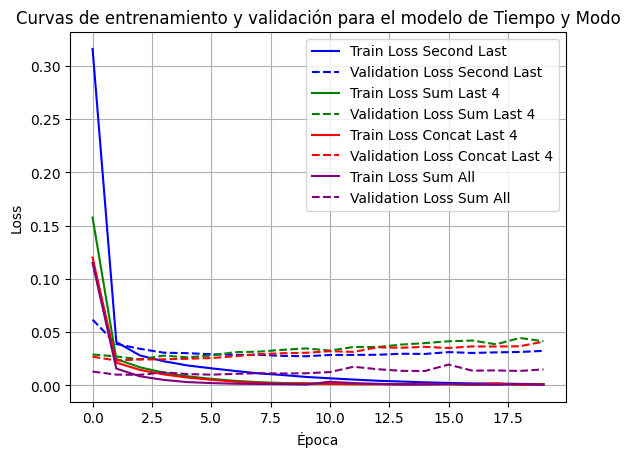

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses_secondlast, label="Train Loss Second Last", color='blue')
plt.plot(val_losses_secondlast, label="Validation Loss Second Last", color='blue', linestyle='--')
plt.plot(train_losses_sumlast4, label="Train Loss Sum Last 4", color='green')
plt.plot(val_losses_sumlast4, label="Validation Loss Sum Last 4", color='green', linestyle='--')
plt.plot(train_losses_concatlast4, label="Train Loss Concat Last 4", color='red')
plt.plot(val_losses_concatlast4, label="Validation Loss Concat Last 4", color='red', linestyle='--')
plt.plot(train_losses_sumall, label="Train Loss Sum All", color='purple')
plt.plot(val_losses_sumall, label="Validation Loss Sum All", color='purple', linestyle='--')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curvas de entrenamiento y validación para el modelo de Tiempo y Modo")
plt.legend()
plt.grid(True)
plt.show()


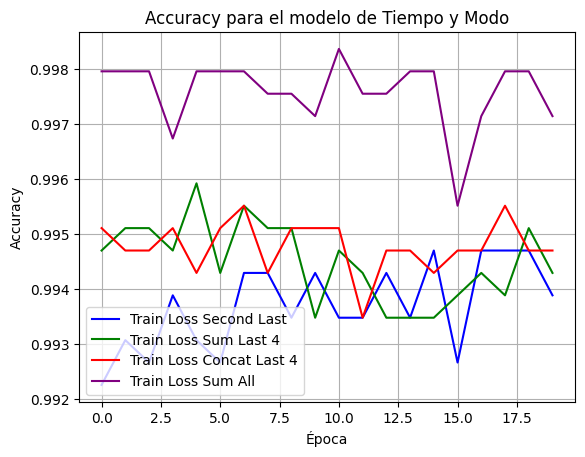

In [ ]:
plt.plot(acc_secondlast, label="Train Loss Second Last", color='blue')
plt.plot(acc_sumlast4, label="Train Loss Sum Last 4", color='green')
plt.plot(acc_concatlast4, label="Train Loss Concat Last 4", color='red')
plt.plot(acc_sumall, label="Train Loss Sum All", color='purple')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy para el modelo de Tiempo y Modo")
plt.legend()
plt.grid(True)
plt.show()

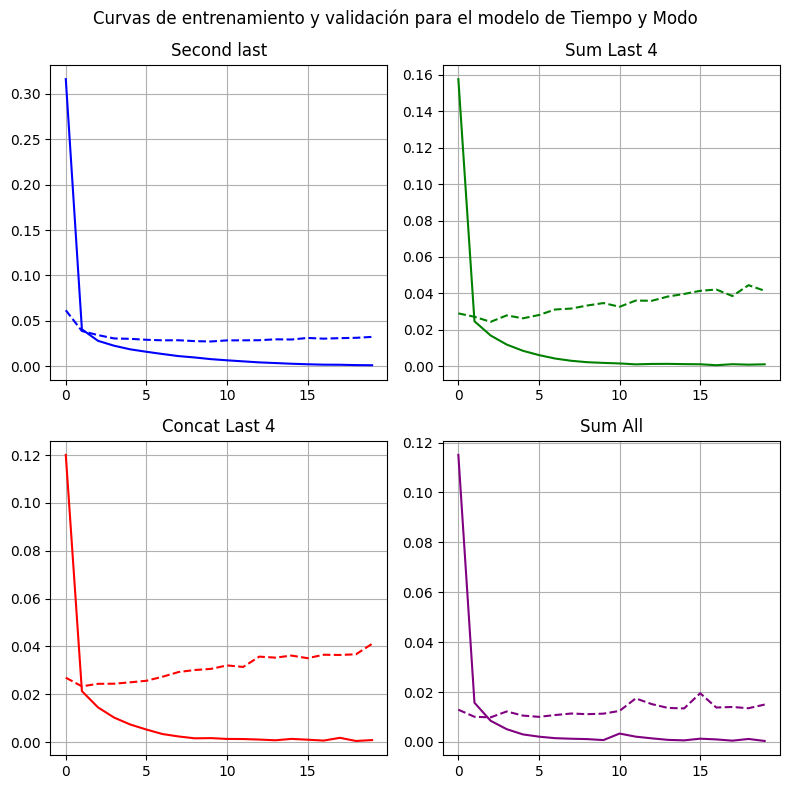

In [ ]:
# Crear una figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Primera gráfica (fila 0, col 0)
axs[0, 0].plot(train_losses_secondlast, color='blue')
axs[0, 0].plot(val_losses_secondlast, color='blue', linestyle='--')
axs[0, 0].set_title('Second last')
axs[0, 0].grid(True)

# Segunda gráfica (fila 0, col 1)
axs[0, 1].plot(train_losses_sumlast4, color='green')
axs[0, 1].plot(val_losses_sumlast4, color='green', linestyle='--')
axs[0, 1].set_title('Sum Last 4')
axs[0, 1].grid(True)

# Tercera gráfica (fila 1, col 0)
axs[1, 0].plot(train_losses_concatlast4, color='red')
axs[1, 0].plot(val_losses_concatlast4, color='red', linestyle='--')
axs[1, 0].set_title('Concat Last 4')
axs[1, 0].grid(True)

# Cuarta gráfica (fila 1, col 1)
axs[1, 1].plot(train_losses_sumall, color='purple')
axs[1, 1].plot(val_losses_sumall, color='purple', linestyle='--')
axs[1, 1].set_title('Sum All')
axs[1, 1].grid(True)


fig.suptitle("Curvas de entrenamiento y validación para el modelo de Tiempo y Modo")

# Ajustar espacio entre subplots
plt.tight_layout()
# Mostrar
plt.show()


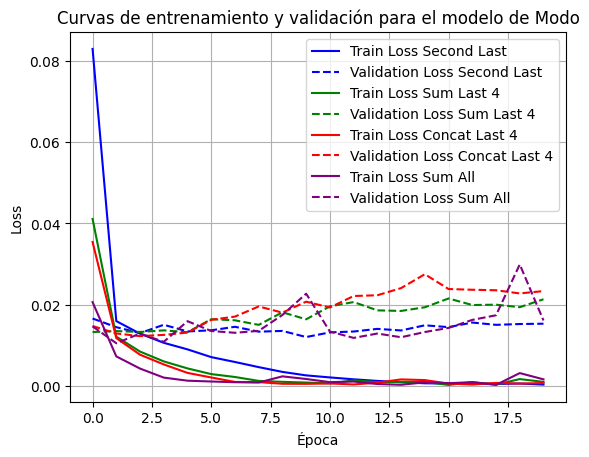

In [ ]:
"""plt.plot(mood_train_losses_secondlast, label="Train Loss Second Last", color='blue')
plt.plot(mood_val_losses_secondlast, label="Validation Loss Second Last", color='blue', linestyle='--')
plt.plot(mood_train_losses_sumlast4, label="Train Loss Sum Last 4", color='green')
plt.plot(mood_val_losses_sumlast4, label="Validation Loss Sum Last 4", color='green', linestyle='--')
plt.plot(mood_train_losses_concatlast4, label="Train Loss Concat Last 4", color='red')
plt.plot(mood_val_losses_concatlast4, label="Validation Loss Concat Last 4", color='red', linestyle='--')
plt.plot(mood_train_losses_sumall, label="Train Loss Sum All", color='purple')
plt.plot(mood_val_losses_sumall, label="Validation Loss Sum All", color='purple', linestyle='--')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curvas de entrenamiento y validación para el modelo de Modo")
plt.legend()
plt.grid(True)
plt.show()"""

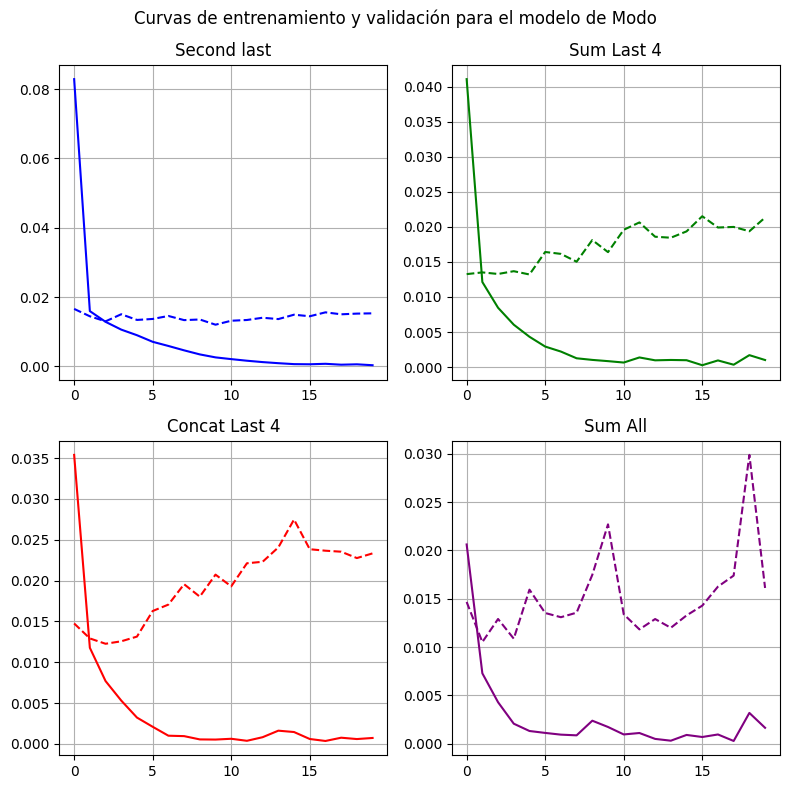

In [ ]:
"""# Crear una figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Primera gráfica (fila 0, col 0)
axs[0, 0].plot(mood_train_losses_secondlast, color='blue')
axs[0, 0].plot(mood_val_losses_secondlast, color='blue', linestyle='--')
axs[0, 0].set_title('Second last')
axs[0, 0].grid(True)

# Segunda gráfica (fila 0, col 1)
axs[0, 1].plot(mood_train_losses_sumlast4, color='green')
axs[0, 1].plot(mood_val_losses_sumlast4, color='green', linestyle='--')
axs[0, 1].set_title('Sum Last 4')
axs[0, 1].grid(True)

# Tercera gráfica (fila 1, col 0)
axs[1, 0].plot(mood_train_losses_concatlast4, color='red')
axs[1, 0].plot(mood_val_losses_concatlast4, color='red', linestyle='--')
axs[1, 0].set_title('Concat Last 4')
axs[1, 0].grid(True)

# Cuarta gráfica (fila 1, col 1)
axs[1, 1].plot(mood_train_losses_sumall, color='purple')
axs[1, 1].plot(mood_val_losses_sumall, color='purple', linestyle='--')
axs[1, 1].set_title('Sum All')
axs[1, 1].grid(True)


fig.suptitle("Curvas de entrenamiento y validación para el modelo de Modo")

# Ajustar espacio entre subplots
plt.tight_layout()
# Mostrar
plt.show()"""

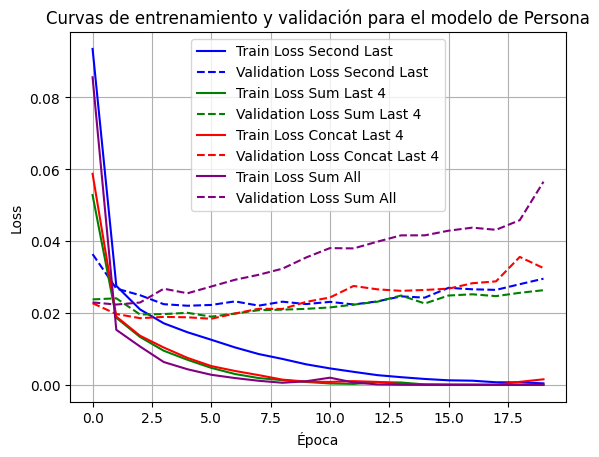

In [ ]:
plt.plot(person_train_losses_secondlast, label="Train Loss Second Last", color='blue')
plt.plot(person_val_losses_secondlast, label="Validation Loss Second Last", color='blue', linestyle='--')
plt.plot(person_train_losses_sumlast4, label="Train Loss Sum Last 4", color='green')
plt.plot(person_val_losses_sumlast4, label="Validation Loss Sum Last 4", color='green', linestyle='--')
plt.plot(person_train_losses_concatlast4, label="Train Loss Concat Last 4", color='red')
plt.plot(person_val_losses_concatlast4, label="Validation Loss Concat Last 4", color='red', linestyle='--')
plt.plot(person_train_losses_sumall, label="Train Loss Sum All", color='purple')
plt.plot(person_val_losses_sumall, label="Validation Loss Sum All", color='purple', linestyle='--')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curvas de entrenamiento y validación para el modelo de Persona")
plt.legend()
plt.grid(True)
plt.show()

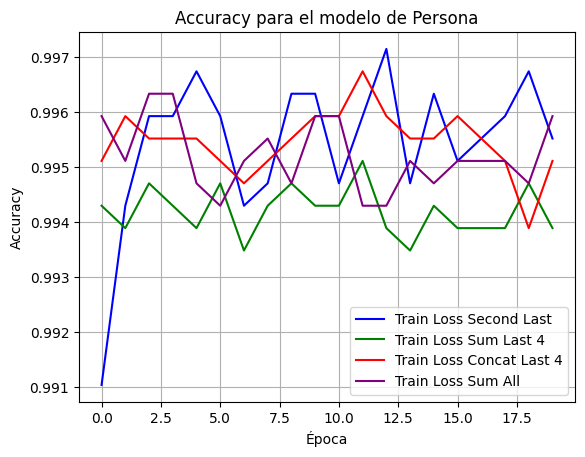

In [ ]:
plt.plot(person_acc_secondlast, label="Train Loss Second Last", color='blue')
plt.plot(person_acc_sumlast4, label="Train Loss Sum Last 4", color='green')
plt.plot(person_acc_concatlast4, label="Train Loss Concat Last 4", color='red')
plt.plot(person_acc_sumall, label="Train Loss Sum All", color='purple')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy para el modelo de Persona")
plt.legend()
plt.grid(True)
plt.show()

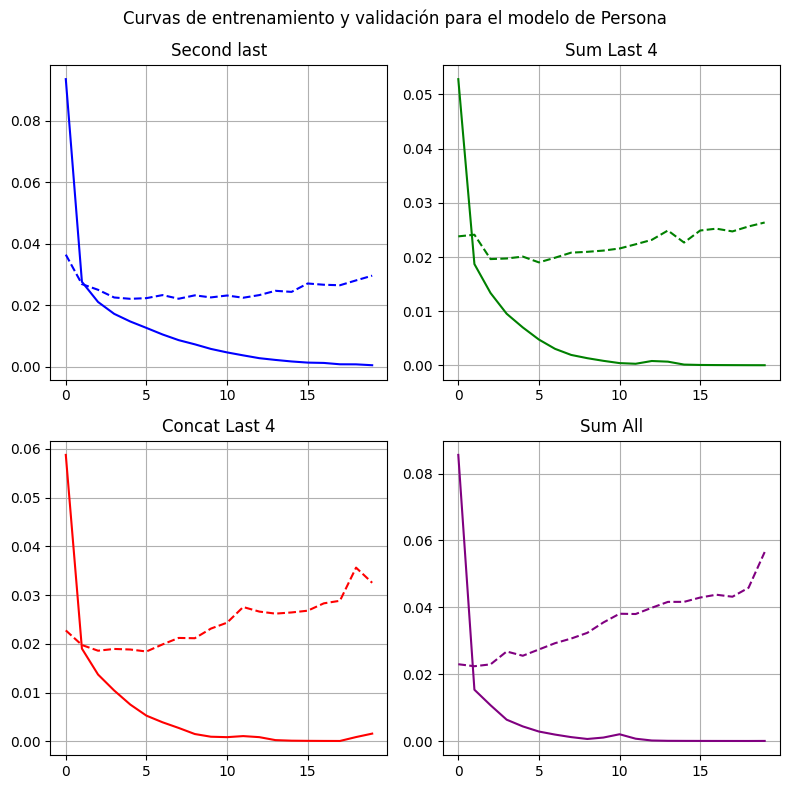

In [ ]:
# Crear una figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Primera gráfica (fila 0, col 0)
axs[0, 0].plot(person_train_losses_secondlast, color='blue')
axs[0, 0].plot(person_val_losses_secondlast, color='blue', linestyle='--')
axs[0, 0].set_title('Second last')
axs[0, 0].grid(True)

# Segunda gráfica (fila 0, col 1)
axs[0, 1].plot(person_train_losses_sumlast4, color='green')
axs[0, 1].plot(person_val_losses_sumlast4, color='green', linestyle='--')
axs[0, 1].set_title('Sum Last 4')
axs[0, 1].grid(True)

# Tercera gráfica (fila 1, col 0)
axs[1, 0].plot(person_train_losses_concatlast4, color='red')
axs[1, 0].plot(person_val_losses_concatlast4, color='red', linestyle='--')
axs[1, 0].set_title('Concat Last 4')
axs[1, 0].grid(True)

# Cuarta gráfica (fila 1, col 1)
axs[1, 1].plot(person_train_losses_sumall, color='purple')
axs[1, 1].plot(person_val_losses_sumall, color='purple', linestyle='--')
axs[1, 1].set_title('Sum All')
axs[1, 1].grid(True)


fig.suptitle("Curvas de entrenamiento y validación para el modelo de Persona")

# Ajustar espacio entre subplots
plt.tight_layout()
# Mostrar
plt.show()

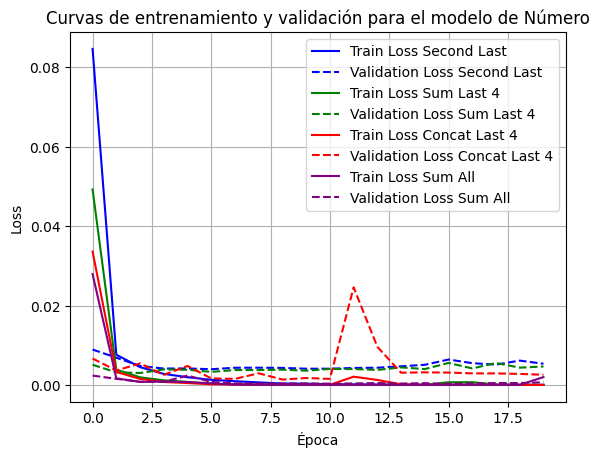

In [ ]:
plt.plot(number_train_losses_secondlast, label="Train Loss Second Last", color='blue')
plt.plot(number_val_losses_secondlast, label="Validation Loss Second Last", color='blue', linestyle='--')
plt.plot(number_train_losses_sumlast4, label="Train Loss Sum Last 4", color='green')
plt.plot(number_val_losses_sumlast4, label="Validation Loss Sum Last 4", color='green', linestyle='--')
plt.plot(number_train_losses_concatlast4, label="Train Loss Concat Last 4", color='red')
plt.plot(number_val_losses_concatlast4, label="Validation Loss Concat Last 4", color='red', linestyle='--')
plt.plot(number_train_losses_sumall, label="Train Loss Sum All", color='purple')
plt.plot(number_val_losses_sumall, label="Validation Loss Sum All", color='purple', linestyle='--')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curvas de entrenamiento y validación para el modelo de Número")
plt.legend()
plt.grid(True)
plt.show()

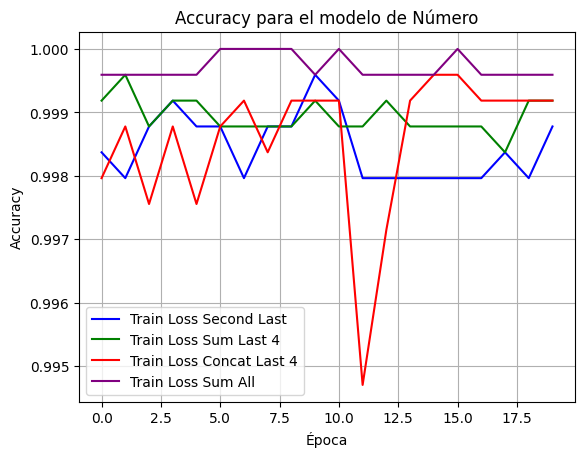

In [ ]:
plt.plot(number_acc_secondlast, label="Train Loss Second Last", color='blue')
plt.plot(number_acc_sumlast4, label="Train Loss Sum Last 4", color='green')
plt.plot(number_acc_concatlast4, label="Train Loss Concat Last 4", color='red')
plt.plot(number_acc_sumall, label="Train Loss Sum All", color='purple')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy para el modelo de Número")
plt.legend()
plt.grid(True)
plt.show()

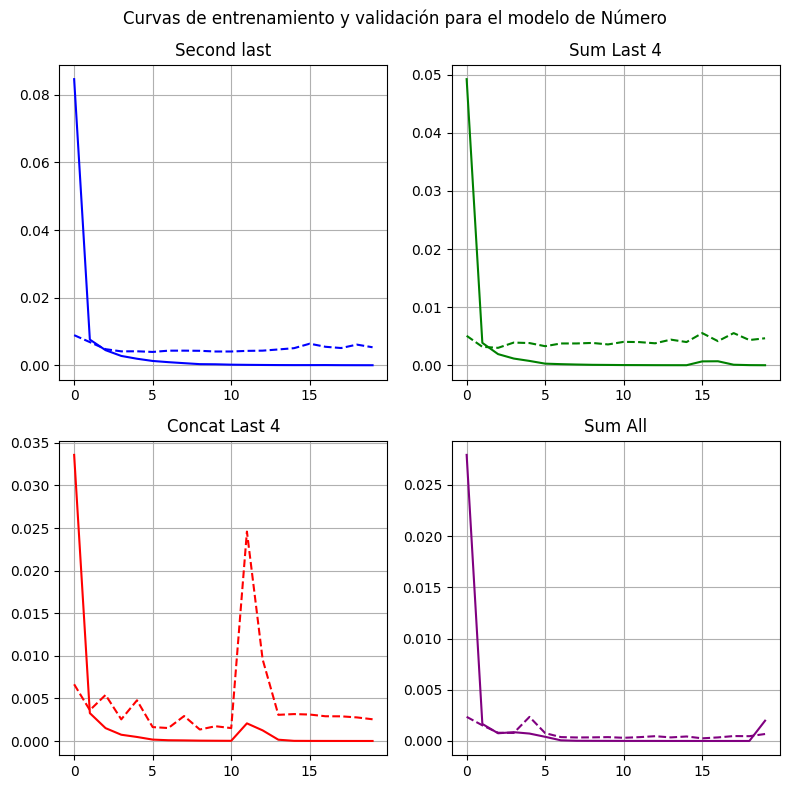

In [ ]:
# Crear una figura con 4 subplots (2 filas, 2 columnas)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Primera gráfica (fila 0, col 0)
axs[0, 0].plot(number_train_losses_secondlast, color='blue')
axs[0, 0].plot(number_val_losses_secondlast, color='blue', linestyle='--')
axs[0, 0].set_title('Second last')
axs[0, 0].grid(True)

# Segunda gráfica (fila 0, col 1)
axs[0, 1].plot(number_train_losses_sumlast4, color='green')
axs[0, 1].plot(number_val_losses_sumlast4, color='green', linestyle='--')
axs[0, 1].set_title('Sum Last 4')
axs[0, 1].grid(True)

# Tercera gráfica (fila 1, col 0)
axs[1, 0].plot(number_train_losses_concatlast4, color='red')
axs[1, 0].plot(number_val_losses_concatlast4, color='red', linestyle='--')
axs[1, 0].set_title('Concat Last 4')
axs[1, 0].grid(True)

# Cuarta gráfica (fila 1, col 1)
axs[1, 1].plot(number_train_losses_sumall, color='purple')
axs[1, 1].plot(number_val_losses_sumall, color='purple', linestyle='--')
axs[1, 1].set_title('Sum All')
axs[1, 1].grid(True)


fig.suptitle("Curvas de entrenamiento y validación para el modelo de Número")

# Ajustar espacio entre subplots
plt.tight_layout()
# Mostrar
plt.show()